In [1]:
# importing  packages

import torch
import torchvision
from torchvision import transforms, datasets, models
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,random_split

from torchsummary import summary

from PIL import Image
import matplotlib.pyplot as plt # plot images and graphs
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random


In [20]:
#  setting up gpu
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [11]:
!nvidia-smi

Fri Jul 25 19:31:14 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.18                 Driver Version: 546.18       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   47C    P5               7W /  65W |    718MiB /  6144MiB |     56%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
print(torch.version.cuda)
print(torch.__version__)

12.1
2.5.1+cu121


In [19]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1}

        noop = lambda x : x
        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x
    

class VGG16(nn.Module):
    def __init__(self, input_size, num_classes=10, batch_norm=False):
        super(VGG16, self).__init__()

        self.in_channels, self.in_width, self.in_height = input_size

        self.block_1 = VGGBlock(self.in_channels, 64, batch_norm=batch_norm)
        self.block_2 = VGGBlock(64, 128, batch_norm=batch_norm)
        self.block_3 = VGGBlock(128, 256, batch_norm=batch_norm)
        self.block_4 = VGGBlock(256,512, batch_norm=batch_norm)

        self.classifier = nn.Sequential(
                nn.Linear(2048, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, num_classes) 
            )

    @property
    def input_size(self):
          return self.in_channels, self.in_width, self.in_height

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [26]:

model = VGG16((1,32,32), batch_norm=True)
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [37]:
import time
def train(loaders, optimizer, criterion, epochs=10, save_param=True, dataset="mnist"):
    global device
    global model
    try:
        model = model.to(device)  # Load model to CUDA

        history_loss = {"train": [], "test": []}
        history_accuracy = {"train": [], "test": []}
        best_test_accuracy = 0  # variable to store the best test accuracy
        
        start_time = time.time()

        for epoch in range(epochs):
            sum_loss = {"train": 0, "test": 0}
            sum_accuracy = {"train": 0, "test": 0}

            for split in ["train", "test"]:
                if split == "train":
                    model.train()
                else:
                    model.eval()
                
                for (inputs, labels) in loaders[split]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    optimizer.zero_grad()  # Reset gradients
                    prediction = model(inputs)
                    labels = labels.long()
                    loss = criterion(prediction, labels)
                    sum_loss[split] += loss.item()  # Update loss

                    if split == "train":
                        loss.backward()  # Compute gradients
                        optimizer.step()  # Optimize
                    
                    _,pred_label = torch.max(prediction, dim = 1)
                    pred_labels = (pred_label == labels).float()

                    batch_accuracy = pred_labels.sum().item() / inputs.size(0)
                    sum_accuracy[split] += batch_accuracy  # Update accuracy
                    
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split] / len(loaders[split]) for split in ["train", "test"]}
            epoch_accuracy = {split: sum_accuracy[split] / len(loaders[split]) for split in ["train", "test"]}

            # Store params at the best test accuracy
            if save_param and epoch_accuracy["test"] > best_test_accuracy:
                torch.save(model.state_dict(), rf"C:\Users\rabia\Documents\random\adversarial-attack-enc\model\vgg16_{dataset}_model.pth")
                best_test_accuracy = epoch_accuracy["test"]

            # Update history
            for split in ["train", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
                
            print(f"Epoch: [{epoch + 1} | {epochs}]\nTrain Loss: {epoch_loss['train']:.4f}, Train Accuracy: {epoch_accuracy['train']:.2f}, \
            Test Loss: {epoch_loss['test']:.4f}, Test Accuracy: {epoch_accuracy['test']:.2f}, Time Taken: {(time.time() - start_time) / 60:.2f} mins")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        
        plt.title("Loss")
        for split in ["train", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        
        plt.title("Accuracy")
        for split in ["train", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [28]:
transform=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root= r'C:\Users\rabia\Documents\random\adversarial-attack-enc\dataset', train = True, download =True, transform = transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000])

test_dataset = datasets.MNIST(root= r'C:\Users\rabia\Documents\random\adversarial-attack-enc\dataset', train = False, download =True, transform = transform)

torch.Size([3, 152, 182])


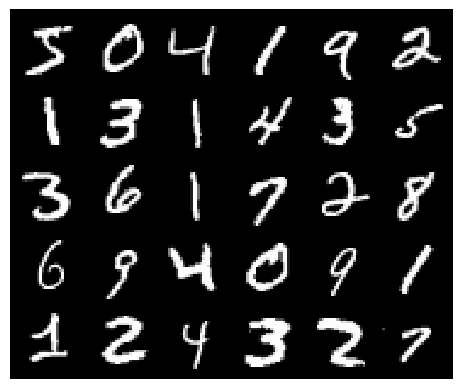

In [31]:
# Extract data and targets
x_train, y_train = dataset.data, dataset.targets


if len(x_train.shape) == 3:
      x_train = x_train.unsqueeze(1)
x_grid = torchvision.utils.make_grid(x_train[:30], nrow=6, padding=2)
print(x_grid.shape)


npimg = x_grid.numpy()
npimg_tr = np.transpose(npimg, (1, 2, 0))
plt.axis('off')
plt.imshow(npimg_tr, interpolation='nearest')

Label: 4


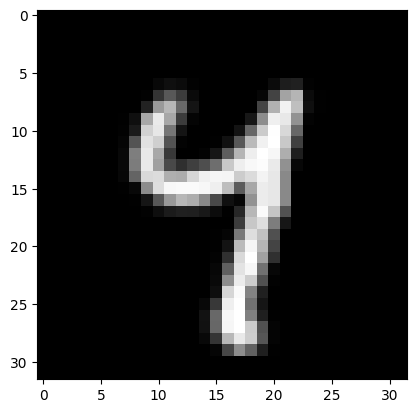

In [33]:
image, label = train_dataset[200]
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

Epoch: [1 | 10]
Train Loss: 0.1358, Train Accuracy: 0.97,             Test Loss: 0.0647, Test Accuracy: 0.98, Time Taken: 0.92 mins
Epoch: [2 | 10]
Train Loss: 0.0946, Train Accuracy: 0.98,             Test Loss: 0.0487, Test Accuracy: 0.99, Time Taken: 1.84 mins
Epoch: [3 | 10]
Train Loss: 0.0739, Train Accuracy: 0.98,             Test Loss: 0.0414, Test Accuracy: 0.99, Time Taken: 2.70 mins
Epoch: [4 | 10]
Train Loss: 0.0627, Train Accuracy: 0.98,             Test Loss: 0.0379, Test Accuracy: 0.99, Time Taken: 3.54 mins
Epoch: [5 | 10]
Train Loss: 0.0524, Train Accuracy: 0.99,             Test Loss: 0.0317, Test Accuracy: 0.99, Time Taken: 4.37 mins
Epoch: [6 | 10]
Train Loss: 0.0458, Train Accuracy: 0.99,             Test Loss: 0.0290, Test Accuracy: 0.99, Time Taken: 5.21 mins
Epoch: [7 | 10]
Train Loss: 0.0391, Train Accuracy: 0.99,             Test Loss: 0.0285, Test Accuracy: 0.99, Time Taken: 6.06 mins
Epoch: [8 | 10]
Train Loss: 0.0347, Train Accuracy: 0.99,             Test L

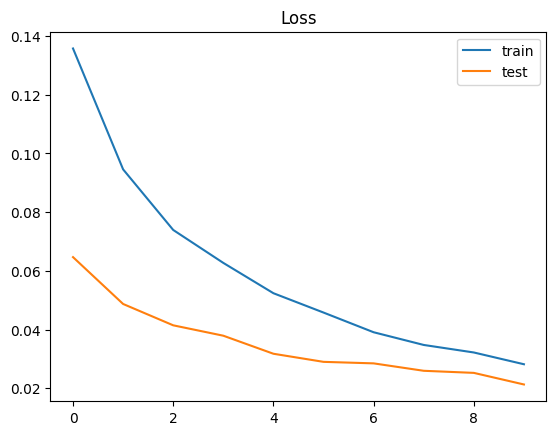

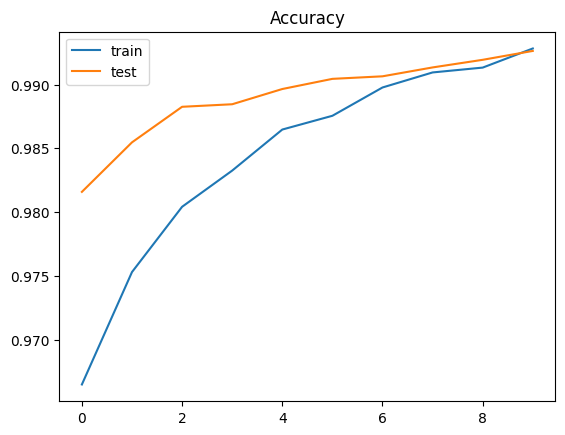

In [39]:
# Set up data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

loaders = {"train": train_loader,
           "test": test_loader}

train(loaders, optimizer, criterion, epochs=10)

In [40]:
train_mnist = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_mnist = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_mnist = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [49]:
transform=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(), 
    
])

dataset = datasets.FashionMNIST(root= r'C:\Users\rabia\Documents\random\adversarial-attack-enc\dataset', train = True, download =True, transform = transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000])

test_dataset = datasets.FashionMNIST(root= r'C:\Users\rabia\Documents\random\adversarial-attack-enc\dataset', train = False, download =True, transform = transform)

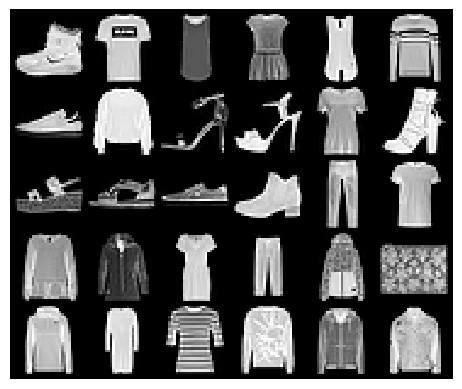

In [50]:
# Extract data and targets
x_train, y_train = dataset.data, dataset.targets


if len(x_train.shape) == 3:
      x_train = x_train.unsqueeze(1)
x_grid = torchvision.utils.make_grid(x_train[:30], nrow=6, padding=2)


npimg = x_grid.numpy()
npimg_tr = np.transpose(npimg, (1, 2, 0))
plt.axis('off')
plt.imshow(npimg_tr, interpolation='nearest')

Label: 9


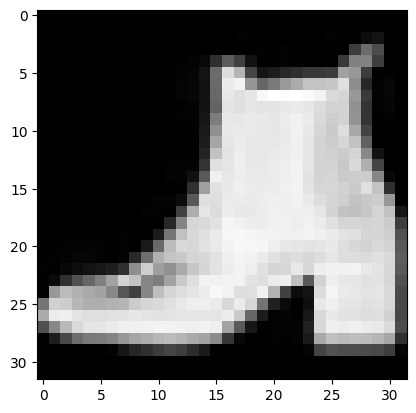

In [51]:
image, label = train_dataset[200]
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

Epoch: [1 | 10]
Train Loss: 0.6191, Train Accuracy: 0.79,             Test Loss: 0.4622, Test Accuracy: 0.83, Time Taken: 0.89 mins
Epoch: [2 | 10]
Train Loss: 0.3874, Train Accuracy: 0.86,             Test Loss: 0.3450, Test Accuracy: 0.88, Time Taken: 1.78 mins
Epoch: [3 | 10]
Train Loss: 0.3285, Train Accuracy: 0.88,             Test Loss: 0.3509, Test Accuracy: 0.87, Time Taken: 2.67 mins
Epoch: [4 | 10]
Train Loss: 0.2882, Train Accuracy: 0.90,             Test Loss: 0.3453, Test Accuracy: 0.88, Time Taken: 3.76 mins
Epoch: [5 | 10]
Train Loss: 0.2584, Train Accuracy: 0.91,             Test Loss: 0.3154, Test Accuracy: 0.89, Time Taken: 4.79 mins
Epoch: [6 | 10]
Train Loss: 0.2350, Train Accuracy: 0.92,             Test Loss: 0.3337, Test Accuracy: 0.89, Time Taken: 5.84 mins
Epoch: [7 | 10]
Train Loss: 0.2136, Train Accuracy: 0.92,             Test Loss: 0.3049, Test Accuracy: 0.90, Time Taken: 6.88 mins
Epoch: [8 | 10]
Train Loss: 0.1939, Train Accuracy: 0.93,             Test L

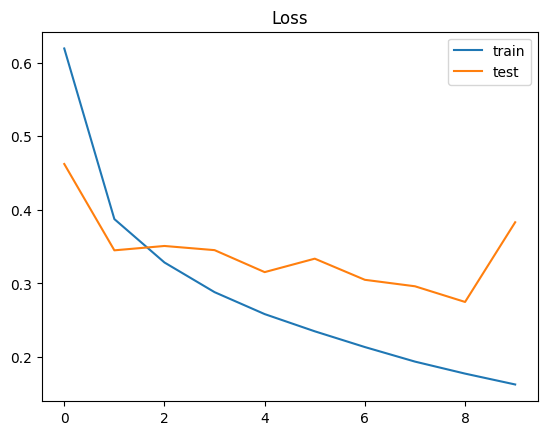

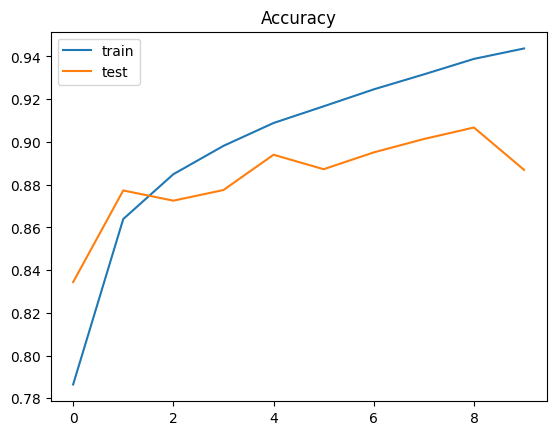

In [52]:
# Set up data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

loaders = {"train": train_loader,
           "test": test_loader}

train(loaders, optimizer, criterion, epochs=10, dataset='fashion-mnist')

In [53]:
train_fmnist = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_fmnist = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_fmnist = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [54]:
##r'C:\Users\rabia\Documents\random\adversarial-attack-enc
# For MNIST
model_mnist = VGG16((1,32,32), batch_norm=True)
model_mnist.to(device)
model_mnist.load_state_dict(torch.load(r'C:\Users\rabia\Documents\random\adversarial-attack-enc\model\vgg16_mnist_model.pth'))


C:\Users\rabia\AppData\Local\Temp\ipykernel_27312\1909811704.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mnist.load_state_dict(torch.load(r'C:\Users\rabia\Docu

<All keys matched successfully>

In [75]:
##r'C:\Users\rabia\Documents\random\adversarial-attack-encadversarial-attack-enc\model\vgg16_fashion-mnist_model.pth
# For FashionMNIST
model_fmnist = VGG16((1,32,32), batch_norm=True)
model_fmnist.to(device)
model_fmnist.load_state_dict(torch.load(r'C:\Users\rabia\Documents\random\adversarial-attack-enc\model\vgg16_fashion-mnist_model.pth'))


C:\Users\rabia\AppData\Local\Temp\ipykernel_27312\2475320257.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_fmnist.load_state_dict(torch.load(r'C:\Users\rabia\Doc

<All keys matched successfully>

In [57]:
## fgsm attack
def perturb(imgs, eps, data_grads):
    sign_data_grads = data_grads.sign()
    adv_imgs = imgs + eps * sign_data_grads
    adv_imgs = torch.clamp(adv_imgs, 0, 1)
    return adv_imgs

def fgsm_attack(model, imgs, labels, eps):
    imgs.required_grad = True
    
    outputs = model(imgs)
    loss = F.nll_loss(outputs, labels)
    
    model.zero_grad()
    loss.backward()
    data_grads = imgs.grad.data
    
    adv_imgs = perturb(imgs, eps, data_grads)
    outputs = model(adv_imgs)
    new_preds = outputs.argmax(axis=1)
    
    return adv_imgs, new_preds




In [58]:
#pgd attack
def pgd_linf(model, imgs, labels, epsilon, alpha, num_iter, flag=0):
    """ Construct PGD adversarial examples on the examples X"""
    delta = torch.zeros_like(imgs, requires_grad=True)
    if flag == 1:
        num_iter = 1
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(imgs + delta), labels)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
        new_preds = model(imgs + delta).argmax(axis=1)
    return (imgs + delta).detach(), new_preds


In [59]:
## autoencoder that reconstructs the image
class ConvAutoencoder_GELU(nn.Module):
    def __init__(self, device, z_dim=10):
        super().__init__()
        self.device = device

        self.encoder_conv2D = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.GELU()
        )

        ## Flatten Layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ## Linear Section
        self.encoder_linear = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.GELU(),
            nn.Linear(128, z_dim),
        )

        self.decoder_linear = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.GELU(),
            nn.Linear(128, 3 * 3 * 32),
            nn.GELU(),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        self.decoder_convt2d = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.GELU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
        )


    def forward(self, x):
        x = self.encoder_conv2D(x)
        x = self.flatten(x)
        x = self.encoder_linear(x)
        noise = torch.randn(x.shape).to(self.device)
        x = x + noise
        
        x = self.decoder_linear(x)
        x = self.unflatten(x)
        x = self.decoder_convt2d(x)
        x = torch.sigmoid(x)
                
        return x


In [60]:
convAE = ConvAutoencoder_GELU(device)
convAE.to(device)

summary(convAE, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]              80
              GELU-2            [-1, 8, 16, 16]               0
            Conv2d-3             [-1, 16, 8, 8]           1,168
       BatchNorm2d-4             [-1, 16, 8, 8]              32
              GELU-5             [-1, 16, 8, 8]               0
            Conv2d-6             [-1, 32, 3, 3]           4,640
              GELU-7             [-1, 32, 3, 3]               0
           Flatten-8                  [-1, 288]               0
            Linear-9                  [-1, 128]          36,992
             GELU-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
           Linear-12                  [-1, 128]           1,408
             GELU-13                  [-1, 128]               0
           Linear-14                  [

In [61]:
class EarlyStopping:
    def __init__(self, tolerance=2, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
                
early_stopping = EarlyStopping()

In [62]:
def load_checkpoint(checkpoint):
    convAE.load_state_dict(checkpoint['convAE_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['train_losses'], checkpoint['val_losses']

def save_checkpoint(checkpoint, model_path):
    torch.save(checkpoint, model_path)

In [82]:
def train(model, num_epochs, attack_type, train_loader, val_loader, load_model=False, file_path=r'C:\Users\rabia\Documents\random\adversarial-attack-enc\defense'):
    train_losses, val_losses = [], []
    if load_model:
        train_losses, val_losses = load_checkpoint(torch.load(file_path))
        print("Loaded pre-trained model ...")
    
    start_epoch = len(train_losses)
    start_time = time.time()
    
    for epoch in range(start_epoch, num_epochs):
        train_loss, val_loss = 0.0, 0.0
        train_count, val_count = 0, 0
        for _, (imgs, labels) in enumerate(train_loader):
            batch_size = imgs.shape[0]
            imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))

            if attack_type == 'fgsm':
                adv_imgs, _ = fgsm_attack(model, imgs, labels, eps_fgsm)
            else:
                adv_imgs, _ = pgd_linf(model, imgs, labels, eps_pgd, alpha, num_iter)
            
            train_count += len(adv_imgs)

            adv_imgs = adv_imgs.to(device)

            optimizer.zero_grad()
            rec_imgs = convAE.forward(adv_imgs)
            loss = criterion(imgs, rec_imgs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size

        for _, (imgs, labels) in enumerate(val_loader):
            batch_size = imgs.shape[0]
            imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))
            if attack_type == 'fgsm':
                adv_imgs, _ = fgsm_attack(model, imgs, labels, eps_fgsm)
            else:
                adv_imgs, _ = pgd_linf(model, imgs, labels, eps_pgd, alpha, num_iter)
            
            val_count += len(adv_imgs)

            adv_imgs = adv_imgs.to(device)

            optimizer.zero_grad()
            rec_imgs = convAE.forward(adv_imgs)
            loss = criterion(imgs, rec_imgs)
            loss.backward()
            optimizer.step()
            val_loss += loss.item() * batch_size

        train_loss, val_loss = train_loss / train_count, val_loss / val_count

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1} / {num_epochs}, Train_loss: {train_loss:.4f}, Val_loss: {val_loss:.4f}, \
              Time_taken: {(time.time()-start_time)/60:.2f} mins')

        checkpoint = {
            'convAE_state_dict': convAE.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses, 'val_losses': val_losses
        }

        save_checkpoint(checkpoint, file_path)
        # early_stopping(train_loss, val_loss)
        # if early_stopping.early_stop:
        #     print("Early Stopping critieria satisfied")
        #     break
            
    # Plot the training and validation loss
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('number of epochs')
    plt.legend()

    plt.show()

In [66]:
def to_numpy_array(tensor):
    '''Convert torch.Tensor to np.ndarray'''
    tensor_ = tensor.cpu()
    tensor_ = tensor_.squeeze(0)
    tensor_ = tensor_.detach().numpy()
    return tensor_

# Visualise the reconstructed image
def visualise(model, val_loader, attack_type):
    count = 0
    for i, (imgs, labels) in enumerate(val_loader):
        if count > 4:
            break
        if i % 3 == 0:
            count += 1
            batch_size = imgs.shape[0]
            imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))

            if attack_type == 'fgsm':
                adv_imgs, _ = fgsm_attack(model, imgs, labels, eps_fgsm)
            else:
                adv_imgs, _ = pgd_linf(model, imgs, labels, eps_pgd, alpha, num_iter)

            adv_imgs = adv_imgs.to(device)

            with torch.no_grad():
                rec_imgs = convAE(adv_imgs)

            imgs, adv_imgs, rec_imgs = to_numpy_array(imgs[0]), to_numpy_array(adv_imgs[0]), to_numpy_array(rec_imgs[0])

            f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
            ax1.imshow(adv_imgs)
            ax1.set_title("Adversarial Image")
            ax2.imshow(rec_imgs)
            ax2.set_title("Recreated Image")
            ax3.imshow(imgs)
            ax3.set_title("Original Image")

In [73]:
import math
from skimage.metrics import structural_similarity as ssim

def batch_compare_images(model, data_loader, device):
    """
    Compare all reconstructed images and original images in a DataLoader.
    Returns average MSE, PSNR, and SSIM.
    """
    model.eval()
    mse_list, psnr_list, ssim_list = [], [], []
    with torch.no_grad():
        for imgs, _ in data_loader:
            imgs = imgs.to(device)
            rec_imgs = model(imgs)
            imgs_np = imgs.cpu().numpy()
            rec_imgs_np = rec_imgs.cpu().numpy()
            for i in range(imgs_np.shape[0]):
                orig = np.squeeze(imgs_np[i])
                rec = np.squeeze(rec_imgs_np[i])
                mse = np.mean((orig - rec) ** 2)
                mse_list.append(mse)
                if mse == 0:
                    psnr = float('inf')
                else:
                    psnr = 20 * math.log10(1.0 / math.sqrt(mse))
                psnr_list.append(psnr)
                ssim_val = ssim(orig, rec, data_range=1)
                ssim_list.append(ssim_val)
    print(f"Average MSE: {np.mean(mse_list):.6f}")
    print(f"Average PSNR: {np.mean(psnr_list):.2f}")
    print(f"Average SSIM: {np.mean(ssim_list):.4f}")
    return mse_list, psnr_list, ssim_list


In [65]:
# Parameters
lr = 0.001
batch_size = 64
num_epochs = 15
z_dim = 10

# FGSM parameters
eps_fgsm = 0.6

# PGD parameters
eps_pgd, alpha, num_iter = 0.15, 1e-2, 40

# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(convAE.parameters(), lr=lr)

Epoch: 1 / 15, Train_loss: 0.0629, Val_loss: 0.0287,               Time_taken: 1.25 mins
Epoch: 2 / 15, Train_loss: 0.0237, Val_loss: 0.0208,               Time_taken: 2.43 mins
Epoch: 3 / 15, Train_loss: 0.0192, Val_loss: 0.0180,               Time_taken: 3.61 mins
Epoch: 4 / 15, Train_loss: 0.0171, Val_loss: 0.0165,               Time_taken: 4.80 mins
Epoch: 5 / 15, Train_loss: 0.0159, Val_loss: 0.0155,               Time_taken: 6.00 mins
Epoch: 6 / 15, Train_loss: 0.0151, Val_loss: 0.0148,               Time_taken: 7.19 mins
Epoch: 7 / 15, Train_loss: 0.0145, Val_loss: 0.0142,               Time_taken: 8.38 mins
Epoch: 8 / 15, Train_loss: 0.0140, Val_loss: 0.0139,               Time_taken: 9.57 mins
Epoch: 9 / 15, Train_loss: 0.0137, Val_loss: 0.0135,               Time_taken: 10.78 mins
Epoch: 10 / 15, Train_loss: 0.0134, Val_loss: 0.0132,               Time_taken: 11.98 mins
Epoch: 11 / 15, Train_loss: 0.0131, Val_loss: 0.0130,               Time_taken: 13.18 mins
Epoch: 12 / 15, 

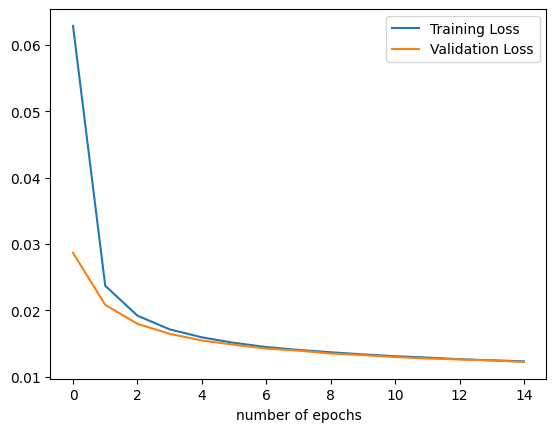

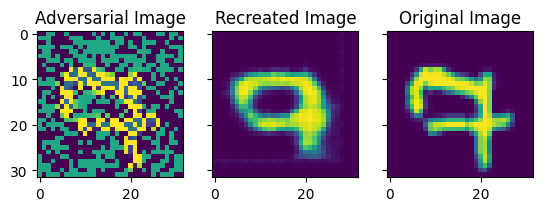

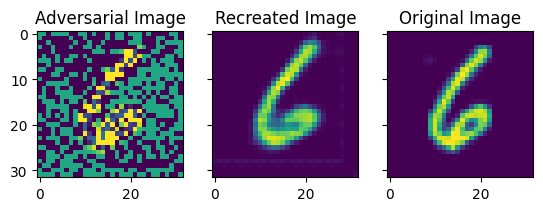

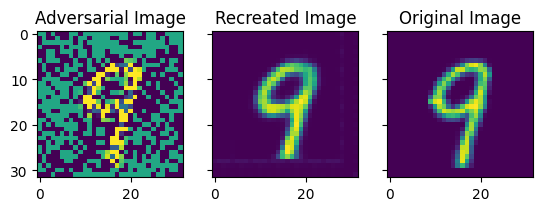

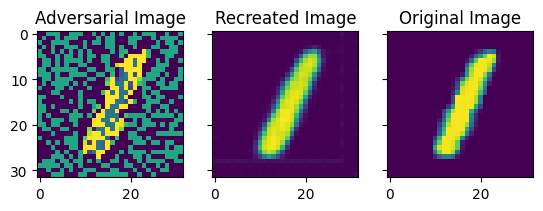

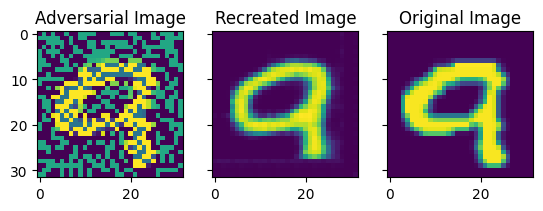

In [68]:
# FGSM Attack on the MNIST Dataset
attack_type = 'fgsm'
file_path = r'C:\Users\rabia\Documents\random\adversarial-attack-enc\defense\ae_mnist_fgsm.pth.tar'
train(model_mnist, num_epochs, attack_type, train_mnist, val_mnist, load_model=False, file_path=file_path)
visualise(model_mnist, val_mnist, attack_type)

In [74]:
batch_compare_images(convAE, val_mnist, device)

Average MSE: 0.028629
Average PSNR: 15.99
Average SSIM: 0.6106


([np.float32(0.03685325),
  np.float32(0.035501488),
  np.float32(0.046665944),
  np.float32(0.05783994),
  np.float32(0.023973912),
  np.float32(0.032298833),
  np.float32(0.040015034),
  np.float32(0.017805673),
  np.float32(0.034670763),
  np.float32(0.028094957),
  np.float32(0.02276254),
  np.float32(0.019455805),
  np.float32(0.034118928),
  np.float32(0.04187133),
  np.float32(0.06828114),
  np.float32(0.012079017),
  np.float32(0.00862949),
  np.float32(0.03285215),
  np.float32(0.045361675),
  np.float32(0.013310103),
  np.float32(0.024700942),
  np.float32(0.015096511),
  np.float32(0.01546615),
  np.float32(0.023017889),
  np.float32(0.007926062),
  np.float32(0.006031202),
  np.float32(0.04651706),
  np.float32(0.036476485),
  np.float32(0.027283248),
  np.float32(0.03940089),
  np.float32(0.020864777),
  np.float32(0.020837476),
  np.float32(0.022174709),
  np.float32(0.027838338),
  np.float32(0.025170576),
  np.float32(0.033096947),
  np.float32(0.03942133),
  np.float32

Epoch: 1 / 15, Train_loss: 0.0303, Val_loss: 0.0273,               Time_taken: 1.23 mins
Epoch: 2 / 15, Train_loss: 0.0267, Val_loss: 0.0262,               Time_taken: 2.49 mins
Epoch: 3 / 15, Train_loss: 0.0258, Val_loss: 0.0255,               Time_taken: 3.75 mins
Epoch: 4 / 15, Train_loss: 0.0252, Val_loss: 0.0250,               Time_taken: 5.00 mins
Epoch: 5 / 15, Train_loss: 0.0249, Val_loss: 0.0247,               Time_taken: 6.26 mins
Epoch: 6 / 15, Train_loss: 0.0245, Val_loss: 0.0245,               Time_taken: 7.52 mins
Epoch: 7 / 15, Train_loss: 0.0243, Val_loss: 0.0242,               Time_taken: 8.77 mins
Epoch: 8 / 15, Train_loss: 0.0240, Val_loss: 0.0240,               Time_taken: 10.02 mins
Epoch: 9 / 15, Train_loss: 0.0239, Val_loss: 0.0238,               Time_taken: 11.28 mins
Epoch: 10 / 15, Train_loss: 0.0237, Val_loss: 0.0236,               Time_taken: 12.53 mins
Epoch: 11 / 15, Train_loss: 0.0236, Val_loss: 0.0235,               Time_taken: 13.80 mins
Epoch: 12 / 15,

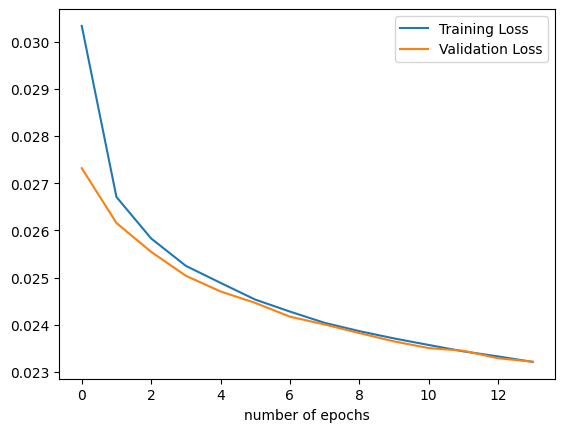

Average MSE: 0.081761
Average PSNR: 11.23
Average SSIM: 0.2401


([np.float32(0.09055207),
  np.float32(0.07318221),
  np.float32(0.08628507),
  np.float32(0.025427036),
  np.float32(0.08663285),
  np.float32(0.058907285),
  np.float32(0.09729257),
  np.float32(0.0636831),
  np.float32(0.04482087),
  np.float32(0.08040837),
  np.float32(0.10006509),
  np.float32(0.09796916),
  np.float32(0.14997439),
  np.float32(0.13265017),
  np.float32(0.03925654),
  np.float32(0.119992524),
  np.float32(0.024589812),
  np.float32(0.09499608),
  np.float32(0.0646579),
  np.float32(0.087965846),
  np.float32(0.10187153),
  np.float32(0.12289387),
  np.float32(0.11644476),
  np.float32(0.11366427),
  np.float32(0.106284544),
  np.float32(0.080402344),
  np.float32(0.11480196),
  np.float32(0.08696226),
  np.float32(0.04995282),
  np.float32(0.07439374),
  np.float32(0.069964856),
  np.float32(0.0961609),
  np.float32(0.040620584),
  np.float32(0.1145673),
  np.float32(0.13187388),
  np.float32(0.059590206),
  np.float32(0.017976368),
  np.float32(0.09056351),
  np.

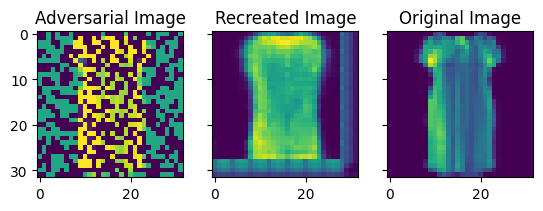

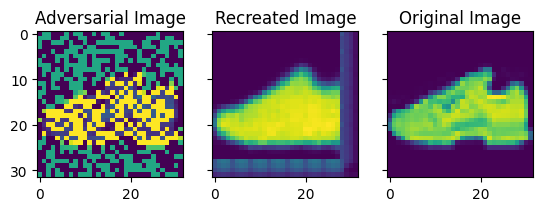

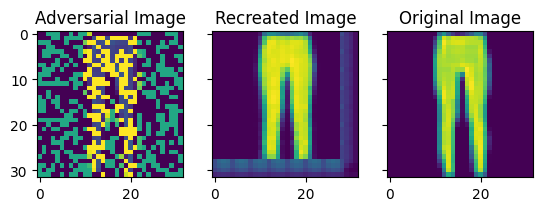

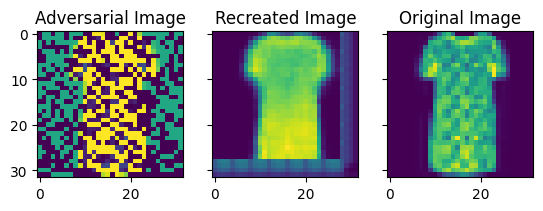

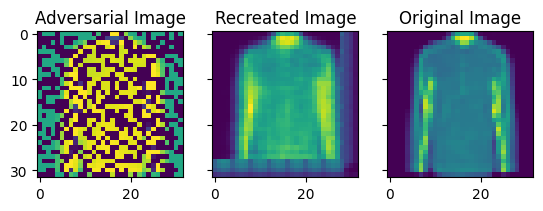

In [76]:
# FGSM Attack on the Fashion-MNIST Dataset
file_path = r'C:\Users\rabia\Documents\random\adversarial-attack-enc\defense\ae_fmnist_fgsm.pth.tar'
train(model_fmnist, num_epochs, attack_type, train_fmnist, val_fmnist, load_model=False, file_path=file_path)
visualise(model_fmnist, val_fmnist, attack_type)
batch_compare_images(convAE, val_fmnist, device)

Epoch: 1 / 5, Train_loss: 0.0169, Val_loss: 0.0132,               Time_taken: 37.12 mins
Early Stopping critieria satisfied


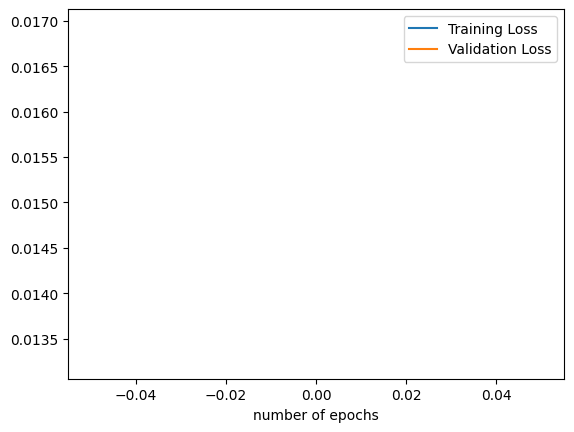

Average MSE: 0.012718
Average PSNR: 19.76
Average SSIM: 0.7908


([np.float32(0.008239385),
  np.float32(0.0087183565),
  np.float32(0.010408422),
  np.float32(0.015596118),
  np.float32(0.022670522),
  np.float32(0.008712105),
  np.float32(0.009011373),
  np.float32(0.008161614),
  np.float32(0.002778416),
  np.float32(0.017006626),
  np.float32(0.013371986),
  np.float32(0.0105049005),
  np.float32(0.011602282),
  np.float32(0.0022299904),
  np.float32(0.011507552),
  np.float32(0.006909676),
  np.float32(0.0109412875),
  np.float32(0.0062277266),
  np.float32(0.010508232),
  np.float32(0.008291123),
  np.float32(0.01634024),
  np.float32(0.013772434),
  np.float32(0.01650358),
  np.float32(0.012503754),
  np.float32(0.02300606),
  np.float32(0.016789565),
  np.float32(0.017866824),
  np.float32(0.022402437),
  np.float32(0.009849261),
  np.float32(0.008817812),
  np.float32(0.01004042),
  np.float32(0.0072143953),
  np.float32(0.008256685),
  np.float32(0.011466932),
  np.float32(0.017251052),
  np.float32(0.001182819),
  np.float32(0.012713604),

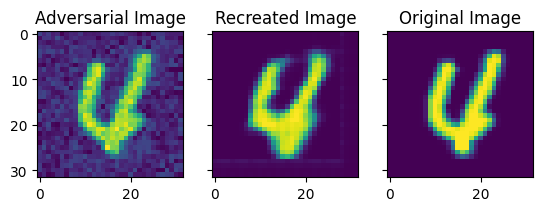

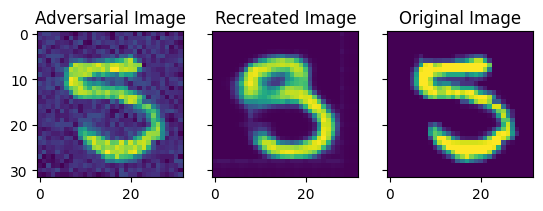

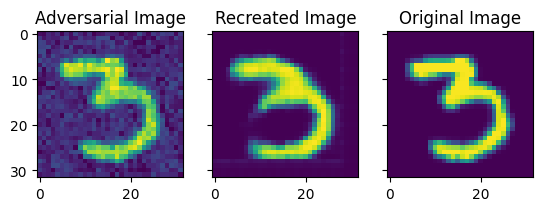

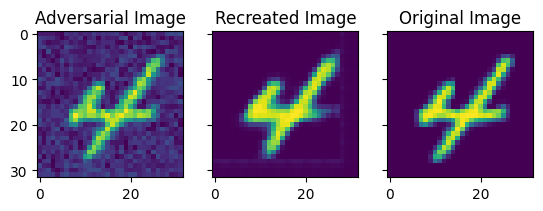

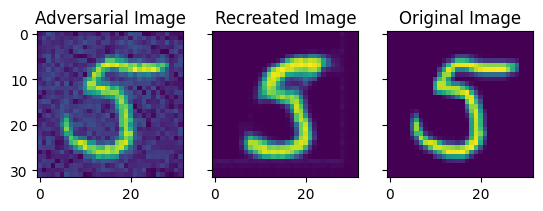

In [77]:
# PGD Attack on the MNIST Dataset
attack_type = 'pgd'
file_path = r'C:\Users\rabia\Documents\random\adversarial-attack-enc\defense\ae_mnist_pgd.pth.tar'
train(model_mnist, 5, attack_type, train_mnist, val_mnist, load_model=False, file_path=file_path)
visualise(model_mnist, val_mnist, attack_type)
batch_compare_images(convAE, val_mnist, device)

In [81]:
counter = EarlyStopping(tolerance=2, min_delta=0.01)
counter.counter

0

In [ ]:
# PGD Attack on the MNIST Dataset
attack_type = 'pgd'
file_path = r'C:\Users\rabia\Documents\random\adversarial-attack-enc\defense\ae_mnist_pgd.pth.tar'
train(model_mnist, 5, attack_type, train_mnist, val_mnist, load_model=False, file_path=file_path)
visualise(model_mnist, val_mnist, attack_type)
batch_compare_images(convAE, val_mnist, device)